In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
import joblib

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from model import GRURegressor, GRUWrapper, SVRRegressor, SVRWrapper, RFRRegressor, RFRWrapper, CatboostRegressor, CatboostWrapper, XGboostRegressor, XGboostWrapper
from utils import Makeloader, create_loaders, prepare_data
from train import evaluate_model, evaluate_model_ML, train_model

import mlflow

In [2]:
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("tool_wear_regression")

# MinIO 설정
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000'  # MinIO port
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'  # MINIO_ROOT_USER
os.environ['AWS_SECRET_ACCESS_KEY'] = 'miniostorage'  # MINIO_ROOT_PASSWORD

# Data 준비

In [3]:
train_dirs = ['/home/scar/Desktop/sanghoon/crois/data/splitted_100ms/T1/',
              '/home/scar/Desktop/sanghoon/crois/data/splitted_100ms/T4/']
test_dirs = ['/home/scar/Desktop/sanghoon/crois/data/splitted_100ms/T5/',
             '/home/scar/Desktop/sanghoon/crois/data/splitted_100ms/T8/'] # Directories containing your data

# Mode: Choose 'Acc', 'Force', or 'Mix'
mode = "Mix"

# Batch size
batch_size = 32

# Train:Validation split ratio (e.g., 0.9 for 90% train, 10% validation)
train_val_ratio = 0.9

In [4]:
# Pytorch 데이터 로더 생성 (Tensor)
train_loader, val_loader = create_loaders(
    directories=train_dirs,
    mode=mode,
    batch_size=batch_size,
    train_val_ratio=train_val_ratio
)
test_loader = create_loaders(
    directories=test_dirs,  # Directories for test data
    mode=mode,
    batch_size=batch_size,
    train_val_ratio=None  # No train/val split for test data
)

# Numpy 입력 모델들용 전처리
X_train, y_train = prepare_data(train_loader)
X_val, y_val = prepare_data(val_loader)
X_test, y_test = prepare_data(test_loader)

# Model 정의

In [5]:
# Hyperparameters for LSTM, GRU
input_size = next(iter(train_loader))[0].shape[1]  # Number of features
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.001
batch_size = 32
epochs = 500

# Initialize 
seed = 42
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def inference_time(model, x):
    start_time = time.time()
    model.predict(x)
    end_time = time.time()
    return end_time - start_time

### GRU Regressor

2025/01/07 09:58:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/07 09:58:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


Epoch 1/200, Train Loss: 41802.8085, Val Loss: 35296.2810
Epoch 2/200, Train Loss: 30205.9129, Val Loss: 25585.1940
Epoch 3/200, Train Loss: 21835.3069, Val Loss: 18411.1475
Epoch 4/200, Train Loss: 15644.7178, Val Loss: 13160.2614
Epoch 5/200, Train Loss: 11221.6242, Val Loss: 9461.9641
Epoch 6/200, Train Loss: 8160.5784, Val Loss: 6983.8518
Epoch 7/200, Train Loss: 6144.7861, Val Loss: 5388.2985
Epoch 8/200, Train Loss: 4899.9376, Val Loss: 4438.1452
Epoch 9/200, Train Loss: 4184.8531, Val Loss: 3918.3834
Epoch 10/200, Train Loss: 3803.4707, Val Loss: 3654.4484
Epoch 11/200, Train Loss: 3621.6347, Val Loss: 3536.2917
Epoch 12/200, Train Loss: 3546.0273, Val Loss: 3489.9475
Epoch 13/200, Train Loss: 3519.0290, Val Loss: 3473.6606
Epoch 14/200, Train Loss: 3510.7154, Val Loss: 3468.6405
Epoch 15/200, Train Loss: 3506.8953, Val Loss: 3467.2915
Epoch 16/200, Train Loss: 3507.0560, Val Loss: 3467.0141
Epoch 17/200, Train Loss: 3506.2972, Val Loss: 3467.0289
Epoch 18/200, Train Loss: 3506.

2025/01/07 09:59:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Evaluation Metrics:
RMSE: 61.2831
MAE: 50.3784
R² Score: -0.1838
MAPE: 29.02%
Explained Variance Score: -0.1518


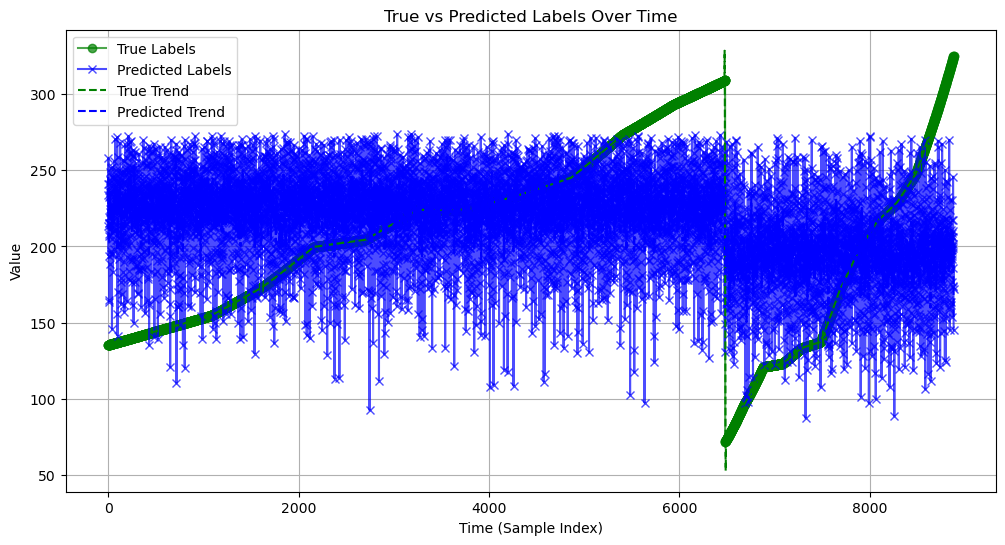

Test Metrics:
RMSE: 61.2831
MAE: 50.3784
R² Score: -0.1838
MAPE: 29.02%
Explained Variance Score: -0.1518
Time taken for inference: 0.0011 seconds


Run ID: 422905fecfd64c7799b6f9e367b41f24
🏃 View run gru_regressor at: http://localhost:8080/#/experiments/4/runs/422905fecfd64c7799b6f9e367b41f24
🧪 View experiment at: http://localhost:8080/#/experiments/4


In [8]:
with mlflow.start_run(description="GRU Regressor", run_name="gru_regressor") as run:
    mlflow.autolog()
    # Log parameters
    epochs = 200
    mlflow.log_params({
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    })
    mlflow.set_tag("model", "GRU")
    mlflow.log_params({
        "train_dirs": train_dirs,
        "test_dirs": test_dirs,
    })

    # Create model
    model = GRURegressor(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=output_size
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=epochs
    )

    # 모델 상태 저장
    model_path = "model.pth"
    preprocessor_path = "preprocessor.pkl"
    model.save(model_path, preprocessor_path)

    # MLflow에 모델 저장
    wrapped_model = GRUWrapper(model)
    mlflow.pyfunc.log_model(
        "model",
        python_model=wrapped_model,
        artifacts={"model": model_path, "preprocessor": preprocessor_path,}
    )

    # Evaluate model
    metrics, all_preds, all_labels = evaluate_model(model, test_loader, device, scaler_path='preprocessor.pkl')

    # Calculate time taken to make predictions
    x_tmp = np.random.rand(1, input_size)
    inference_time_taken = inference_time(model, x_tmp)

    # Log metrics
    mlflow.log_metric("rmse", metrics["rmse"])
    mlflow.log_metric("mae", metrics["mae"])
    mlflow.log_metric("mape", metrics["mape"])
    mlflow.log_metric("r2", metrics["r2"])
    mlflow.log_metric("evs", metrics["explained_variance_score"])

    mlflow.log_metric("inference_time", inference_time_taken)

    print(f"Test Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"Explained Variance Score: {metrics['explained_variance_score']:.4f}")
    print(f"Time taken for inference: {inference_time_taken:.4f} seconds")

    print("\n\nRun ID:", run.info.run_id)

### SVR

2025/01/07 09:59:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/07 09:59:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


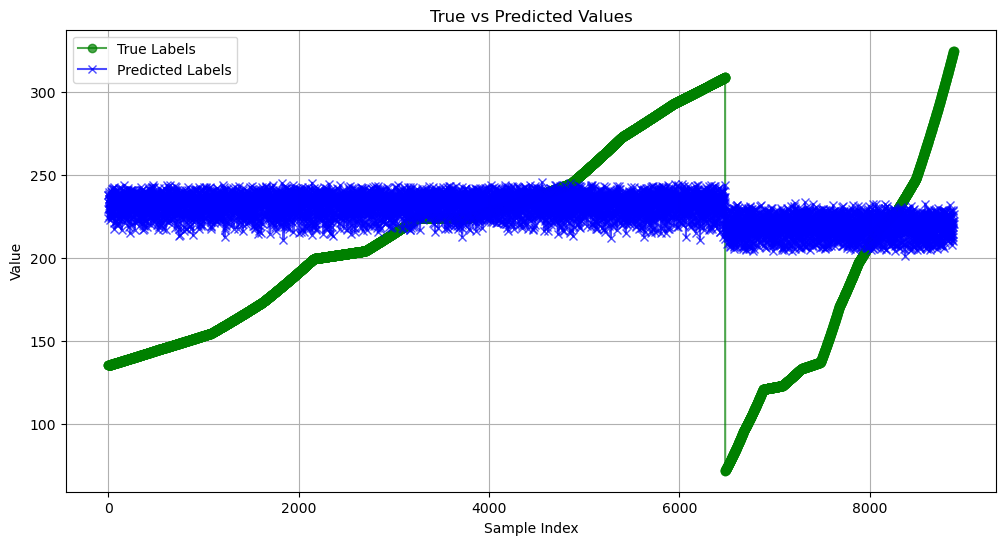

2025/01/07 09:59:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Metrics:
RMSE: 59.7699
MAE: 48.5659
R² Score: -0.1261
MAPE: 30.15%
Explained Variance Score: 0.0376
Time taken for inference: 0.0069 seconds


Run ID: f59cb9c553094b5d9ebe5bb9c7409d33
🏃 View run support_vector_regressor at: http://localhost:8080/#/experiments/4/runs/f59cb9c553094b5d9ebe5bb9c7409d33
🧪 View experiment at: http://localhost:8080/#/experiments/4


In [9]:
with mlflow.start_run(description="Support Vector Regressor", run_name="support_vector_regressor") as run:
    mlflow.autolog()
    # Log parameters
    mlflow.log_params({
        "kernel": "rbf",
        "C": 1.0,
        "epsilon": 0.1
    })
    mlflow.set_tag("model", "SVR")
    mlflow.log_params({
        "train_dirs": train_dirs,
        "test_dirs": test_dirs,
    })

    # Create model
    model = SVRRegressor(kernel="rbf", C=1.0, epsilon=0.1)

    # Train model
    X_train_scaled = model.preprocessor.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    metrics, all_preds, all_test = evaluate_model_ML(model, X_test, y_test)

    # Time taken to make predictions
    x_tmp = np.random.rand(1, input_size)
    inference_time_taken = inference_time(model, x_tmp)

    # Save model
    model_path = "model.pkl"
    preprocessor_path = "preprocessor.pkl"
    model.save(model_path, preprocessor_path)


    # MLflow에 모델 저장
    wrapped_model = SVRWrapper(model)
    mlflow.pyfunc.log_model(
        "model",
        python_model=wrapped_model,
        artifacts={"model": model_path, "preprocessor": preprocessor_path,}
    )

    # Log metrics
    mlflow.log_metric("rmse", metrics["rmse"])
    mlflow.log_metric("mae", metrics["mae"])
    mlflow.log_metric("mape", metrics["mape"])
    mlflow.log_metric("r2", metrics["r2"])
    mlflow.log_metric("evs", metrics["explained_variance_score"])

    mlflow.log_metric("inference_time", inference_time_taken)

    print(f"Test Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"Explained Variance Score: {metrics['explained_variance_score']:.4f}")
    print(f"Time taken for inference: {inference_time_taken:.4f} seconds")

    print("\n\nRun ID:", run.info.run_id)

### RFR

2025/01/07 09:59:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/07 09:59:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


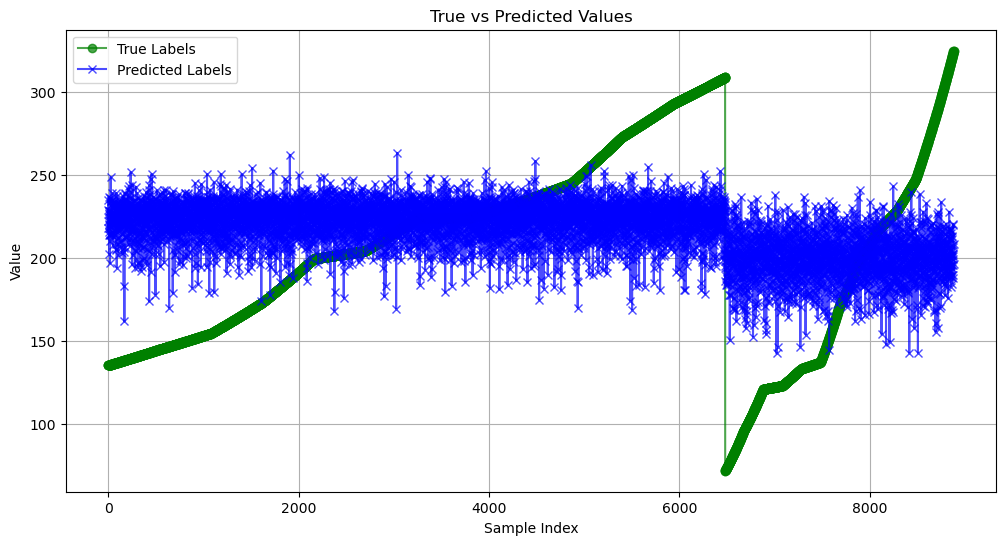

Test Metrics:
RMSE: 56.5066
MAE: 46.4292
R² Score: -0.0065
MAPE: 27.40%
Explained Variance Score: 0.0312
Time taken for inference: 0.0148 seconds


Run ID: f8b67f0814ff41aaa350bc5ca5cc9465
🏃 View run random_forest_regressor at: http://localhost:8080/#/experiments/4/runs/f8b67f0814ff41aaa350bc5ca5cc9465
🧪 View experiment at: http://localhost:8080/#/experiments/4


In [10]:
with mlflow.start_run(description="Random Forest Regressor", run_name="random_forest_regressor") as run:
    mlflow.autolog()
    # Log parameters
    mlflow.log_params({
        "n_estimators": 100,
        "max_depth": 10,
        "random_state": 42
    })
    mlflow.set_tag("model", "RFR")
    mlflow.log_params({
        "train_dirs": train_dirs,
        "test_dirs": test_dirs,
    })

    # Create model
    model = RFRRegressor(n_estimators=100, max_depth=10, random_state=42)

    # Train model
    X_train_scaled = model.preprocessor.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    metrics, all_preds, all_test = evaluate_model_ML(model, X_test, y_test)

    # Time taken to make predictions
    x_tmp = np.random.rand(1, input_size)
    inference_time_taken = inference_time(model, x_tmp)

    # Save model
    model_path = "model.pkl"
    preprocessor_path = "preprocessor.pkl"
    model.save(model_path, preprocessor_path)

    # MLflow에 모델 저장
    wrapped_model = RFRWrapper(model)
    

    # Log metrics
    mlflow.log_metric("rmse", metrics["rmse"])
    mlflow.log_metric("mae", metrics["mae"])
    mlflow.log_metric("mape", metrics["mape"])
    mlflow.log_metric("r2", metrics["r2"])
    mlflow.log_metric("evs", metrics["explained_variance_score"])
    
    mlflow.log_metric("inference_time", inference_time_taken)

    print(f"Test Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"Explained Variance Score: {metrics['explained_variance_score']:.4f}")
    print(f"Time taken for inference: {inference_time_taken:.4f} seconds")


    print("\n\nRun ID:", run.info.run_id)


### Catboost

2025/01/07 09:59:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/07 09:59:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


0:	learn: 59.1946683	test: 57.3579994	best: 57.3579994 (0)	total: 19.7ms	remaining: 39.4s
1:	learn: 59.1703590	test: 57.3394724	best: 57.3394724 (1)	total: 33.7ms	remaining: 33.6s
2:	learn: 59.1504059	test: 57.3232163	best: 57.3232163 (2)	total: 47.7ms	remaining: 31.8s
3:	learn: 59.1347395	test: 57.3096222	best: 57.3096222 (3)	total: 62ms	remaining: 30.9s
4:	learn: 59.1174435	test: 57.2951364	best: 57.2951364 (4)	total: 75.6ms	remaining: 30.1s
5:	learn: 59.0989652	test: 57.2797702	best: 57.2797702 (5)	total: 89.6ms	remaining: 29.8s
6:	learn: 59.0768489	test: 57.2624844	best: 57.2624844 (6)	total: 104ms	remaining: 29.5s
7:	learn: 59.0591969	test: 57.2481323	best: 57.2481323 (7)	total: 117ms	remaining: 29.2s
8:	learn: 59.0316524	test: 57.2295087	best: 57.2295087 (8)	total: 132ms	remaining: 29.2s
9:	learn: 59.0090401	test: 57.2120148	best: 57.2120148 (9)	total: 146ms	remaining: 29.1s
10:	learn: 58.9923987	test: 57.1980005	best: 57.1980005 (10)	total: 160ms	remaining: 28.9s
11:	learn: 58.9

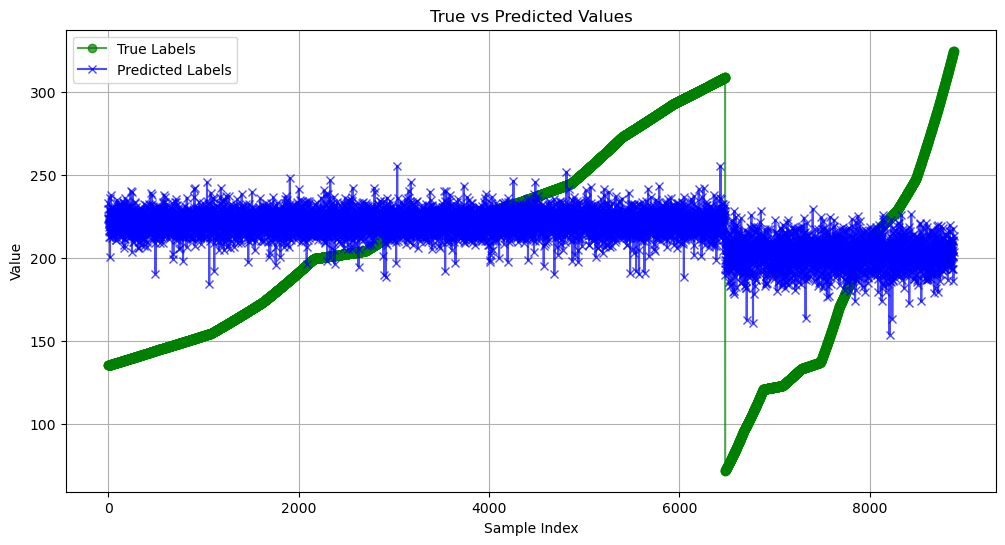

2025/01/07 10:00:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Metrics:
RMSE: 55.9882
MAE: 45.9221
R² Score: 0.0119
MAPE: 27.26%
Explained Variance Score: 0.0486
Time taken for inference: 0.0005 seconds


Run ID: 972851af849743b796aaf143f999ebbb
🏃 View run catboost at: http://localhost:8080/#/experiments/4/runs/972851af849743b796aaf143f999ebbb
🧪 View experiment at: http://localhost:8080/#/experiments/4


In [11]:
with mlflow.start_run(description="Catboost", run_name="catboost") as run:
    mlflow.autolog()
    # Log parameters
    mlflow.log_params({
        "iterations": 2000,
        "learning_rate": 0.01,
        "depth": 8,
        "loss_function": "RMSE",
        "task_type": "GPU" if torch.cuda.is_available() else "CPU"
    })

    mlflow.set_tag("model", "Catboost")
    mlflow.log_params({
        "train_dirs": train_dirs,
        "test_dirs": test_dirs,
    })

    # Create model
    model = CatboostRegressor(iterations=2000, learning_rate=0.01, depth=8, loss_function="RMSE", task_type="GPU" if torch.cuda.is_available() else "CPU", verbose=100)

    # Train model
    X_train_scaled = model.preprocessor.fit_transform(X_train)
    X_test_scaled = model.preprocessor.transform(X_test)
    model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=True)

    # Evaluate model
    metrics, all_preds, all_test = evaluate_model_ML(model, X_test, y_test)

    # Time taken to make predictions
    x_tmp = np.random.rand(1, input_size)
    inference_time_taken = inference_time(model, x_tmp)

    # Save model
    model_path = "catboost_model.cb"
    preprocessor_path = "preprocessor.pkl"
    model.save(model_path, preprocessor_path)

    # MLflow에 모델 저장
    wrapped_model = CatboostWrapper(model)
    mlflow.pyfunc.log_model(
        "model",
        python_model=wrapped_model,
        artifacts={"model": model_path, "preprocessor": preprocessor_path,}
    )

    # Log metrics
    mlflow.log_metric("rmse", metrics["rmse"])
    mlflow.log_metric("mae", metrics["mae"])
    mlflow.log_metric("mape", metrics["mape"])
    mlflow.log_metric("r2", metrics["r2"])
    mlflow.log_metric("evs", metrics["explained_variance_score"])

    mlflow.log_metric("inference_time", inference_time_taken)

    print(f"Test Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"Explained Variance Score: {metrics['explained_variance_score']:.4f}")
    print(f"Time taken for inference: {inference_time_taken:.4f} seconds")


    print("\n\nRun ID:", run.info.run_id)
    

### XGBoost

2025/01/07 10:00:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/07 10:00:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


[0]	validation_0-rmse:57.35061


/home/scar/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:00:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "task_type" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:56.36767
[200]	validation_0-rmse:56.69814
[300]	validation_0-rmse:57.27498
[400]	validation_0-rmse:57.84518
[500]	validation_0-rmse:58.39337
[600]	validation_0-rmse:58.91309
[700]	validation_0-rmse:59.40871
[800]	validation_0-rmse:59.86597
[900]	validation_0-rmse:60.32498
[1000]	validation_0-rmse:60.79616
[1100]	validation_0-rmse:61.31598
[1200]	validation_0-rmse:61.79430
[1300]	validation_0-rmse:62.28416
[1400]	validation_0-rmse:62.70786
[1500]	validation_0-rmse:63.15084
[1600]	validation_0-rmse:63.55618
[1700]	validation_0-rmse:63.91868
[1800]	validation_0-rmse:64.29764
[1900]	validation_0-rmse:64.66356
[1999]	validation_0-rmse:65.02636


2025/01/07 10:00:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/scar/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:00:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


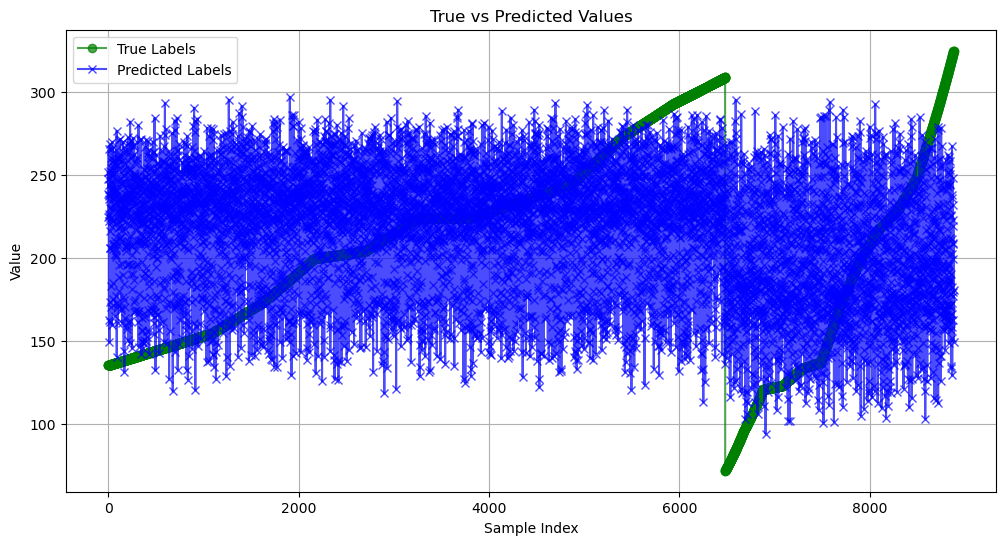

2025/01/07 10:00:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Metrics:
RMSE: 65.0264
MAE: 53.1160
R² Score: -0.3329
MAPE: 30.32%
Explained Variance Score: -0.3003
Time taken for inference: 0.0076 seconds


Run ID: f0e3749ab7314a1cb7855a049d89252a
🏃 View run xgboost at: http://localhost:8080/#/experiments/4/runs/f0e3749ab7314a1cb7855a049d89252a
🧪 View experiment at: http://localhost:8080/#/experiments/4


In [12]:
with mlflow.start_run(description="XGBoost", run_name="xgboost") as run:
    mlflow.autolog()

    # Log parameters
    mlflow.log_params({
        "n_estimators": 2000,
        "max_depth": 8,
        "learning_rate": 0.01,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "task_type": "GPU" if torch.cuda.is_available() else "CPU"
    })

    mlflow.set_tag("model", "XGBoost")
    mlflow.log_params({
        "train_dirs": train_dirs,
        "test_dirs": test_dirs,
    })

    # Create model
    model = XGboostRegressor(n_estimators=2000, max_depth=8, learning_rate=0.01, objective="reg:squarederror", eval_metric="rmse", task_type="GPU" if torch.cuda.is_available() else "CPU", verbosity=1)

    # Train model
    X_train_scaled = model.preprocessor.fit_transform(X_train)
    X_test_scaled = model.preprocessor.transform(X_test)
    model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=100)

    # Evaluate model
    metrics, all_preds, all_test = evaluate_model_ML(model, X_test, y_test)

    # Time taken to make predictions
    x_tmp = np.random.rand(1, input_size)
    inference_time_taken = inference_time(model, x_tmp)

    # Save model
    model_path = "model.pkl"
    preprocessor_path = "preprocessor.pkl"
    model.save(model_path, preprocessor_path)

    # MLflow에 모델 저장
    wrapped_model = XGboostWrapper(model)
    mlflow.pyfunc.log_model(
        "model",
        python_model=wrapped_model,
        artifacts={"model": model_path, "preprocessor": preprocessor_path,}
    )

    # Log metrics
    mlflow.log_metric("rmse", metrics["rmse"])
    mlflow.log_metric("mae", metrics["mae"])
    mlflow.log_metric("mape", metrics["mape"])
    mlflow.log_metric("r2", metrics["r2"])
    mlflow.log_metric("evs", metrics["explained_variance_score"])

    mlflow.log_metric("inference_time", inference_time_taken)

    print(f"Test Metrics:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"Explained Variance Score: {metrics['explained_variance_score']:.4f}")
    print(f"Time taken for inference: {inference_time_taken:.4f} seconds")


    print("\n\nRun ID:", run.info.run_id)
    